In [39]:
import numpy as np
import pandas as pd
import seaborn as sns

# EDA
train = pd.read_csv("/kaggle/input/titanic/train.csv")
#train.head
train.info
# train.shape
# train.isnull().sum()
# train['Embarked'].value_counts()
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [40]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

549 passengers died, and 342 passengers survived. Of those survivng passengers, what characteristics did they have that may have contributed to their survival? 

In [41]:
train['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

64% of the passengers are male, and 35% of the passengers are female. Because there are more male passengers, it can be mistakenly concluded that being male came with a higher chance of surviving/not surviving. We wouldn't necessarily know if the same could be said for female passengers, as there isn't an equal amount of them and therefore their results to compare to males, and vice-versa.

In [42]:
my_agg=(train
 .groupby(['Sex','Survived'])
 .agg(
     fates=pd.NamedAgg('Survived', 'count')))
print(my_agg)

                 fates
Sex    Survived       
female 0            81
       1           233
male   0           468
       1           109


More females survived than died, and more males died than survived. What other factors might have played into this?

In [43]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [44]:
class Quantile:
    def __init__(self, q):
        self.q=q
    def __call__(self, x):
        return x.quantile(self.q)
    

df=train.groupby(['Sex', 'Survived', 'Age'], as_index=False)\
        .agg(
            cnt=('Age', 'count'))

In [45]:
train.where(train.Age <= 20)\
    .groupby([train.Sex,train.Survived])\
    .agg(
        under21=pd.NamedAgg('Survived', 'count'))

under21
Sex    Survived         
female 0              24
       1              53
male   0              73
       1              29

In [46]:
train.groupby(['Sex', 
               'Survived', 
               pd.cut(x=train['Age'],
                      bins=train['Age'].quantile([0,.25,.5,.75,1]),
                      labels=['0-20','21-28','29-38','38-80'])
              ])\
      .size()\
      .unstack()

Age              0-20  21-28  29-38  38-80
Sex    Survived                           
female 0           24     16     10     14
       1           53     47     51     46
male   0           73    101     89     97
       1           28     19     25     20

In [47]:
# Visualizing using bar graph
df

,Sex,Survived,Age,cnt
0,female,0,2.0,4
1,female,0,3.0,1
2,female,0,6.0,1
3,female,0,8.0,1
4,female,0,9.0,4
...,...,...,...,...
211,male,1,52.0,1
212,male,1,56.0,1
213,male,1,60.0,1
214,male,1,62.0,1


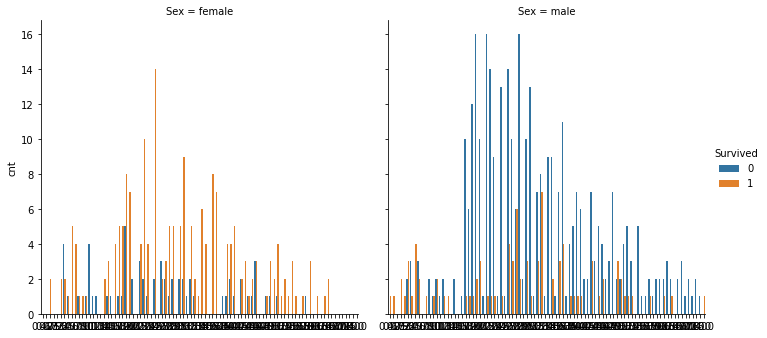

In [48]:
fg = sns.catplot(x='Age', y='cnt', hue='Survived', col='Sex', data=df, kind='bar')
fg.set_xlabels('') # TRY TO SEE IF YOU CAN STANDARDIZE OR NORMALIZE THE DATA SO THAT IT DOESNT LOOK SKEWED. REMEMBER THAT 64%  OF
# PASSENGERS ARE MALE AND 35% ARE FEMALE IN THIS PARTICULAR DATASET

The graphs could be mistakenly interpreted as "dying was more prevalent in the male population than the female population" without considering that there might've just been more of the male population for events to happen to. To prevent this, standardization has to occur on the counts goruped by the 'Sex' column.

In [51]:
df2=train.groupby(['Sex',
              pd.cut(x=train['Age'],
                      bins=train['Age'].quantile([0,.25,.5,.75,1]),
                      labels=['0-20','21-28','29-38','38-80'])
              ])['Survived']\
    .value_counts(normalize=True)\
    .to_frame()

In [52]:
fg = sns.catplot(x='Age', y='Survived', hue='Survived', col='Sex', data=df2, kind='bar')
fg.set_xlabels('') # TRY TO SEE IF YOU CAN STANDARDIZE OR NORMALIZE THE DATA SO THAT IT DOESNT LOOK SKEWED. REMEMBER THAT 64%  OF
# PASSENGERS ARE MALE AND 35% ARE FEMALE IN THIS PARTICULAR DATASET

ValueError: Could not interpret input 'Age'

In [53]:
df2

Survived
Sex    Age   Survived          
female 0-20  1         0.688312
             0         0.311688
       21-28 1         0.746032
             0         0.253968
       29-38 1         0.836066
             0         0.163934
       38-80 1         0.766667
             0         0.233333
male   0-20  0         0.722772
             1         0.277228
       21-28 0         0.841667
             1         0.158333
       29-38 0         0.780702
             1         0.219298
       38-80 0         0.829060
             1         0.170940